## Distribution of Variance in Trade Volume
By John Loeber

Notebook released under the Creative Commons Attribution 4.0 License.

---

In this notebook, I'm going to investigate the distribution of **variance in trade volume**. I will restrict the investigation to equities satisfying the following criteria:
- Sector: Technology ([Morningstar ID](https://www.equitieslab.com/wiki/admin/morningstar-sector) 311)
- Market Cap: $1b+

This is part of a larger project: I am currently working on optimizing stop-losses, and I'm developing volume-based metrics for classifying stocks for that purpose. The conclusion of this notebook -- that **variance in trade volume is approximately log-normally distributed** (for equities satisfying the above criteria) -- is an important result in that context, as it allows us to make powerful statistical assumptions about the structure of trade volume data.

In [162]:
# import necessary libraries
import datetime
import numpy
import matplotlib
from matplotlib import pyplot
import math
from collections import Counter
from scipy import stats

# initialize fundamentals in the notebook
# fundamentals: https://www.quantopian.com/help#ide-fundamentals
fundamentals = init_fundamentals()

In [124]:
# helper function
def addDays(s,n):
    """ takes a date in string format and adds n days to it"""
    end = datetime.datetime.strptime(s,'%Y-%m-%d') + datetime.timedelta(days=n)
    return end.strftime('%Y-%m-%d')

In [3]:
# grab appropriate data, organize by year
dates = ['2002-01-03', '2003-01-03', '2004-01-03', '2005-01-03', '2006-01-03', '2007-01-03', 
        '2008-01-03', '2009-01-03', '2010-01-03', '2011-01-03', '2012-01-03', '2013-01-03', '2014-01-03']
years = range(2002,2015)

In [108]:
# create a dictionary that maps every year in the time period to a list of equities (by sid)
# under consideration for that year
tablesPerYear = {}

for i in range(13):
    # query the fundamentals dataset to get equities fitting our criteria
    tablesPerYear[years[i]] = [x.sid for x in list(get_fundamentals(query()
                            .filter(fundamentals.asset_classification.morningstar_sector_code == 311)
                            .filter(fundamentals.valuation.market_cap > 1000000000)
                           , dates[i]))]

In [125]:
# go through the dictionary and get data on trade volumes and variances for a given period

def getMultiDayData(periods,n):
    """where n = number of days, periods = list of dates to start at"""
    # dicts mapping years to lists of trade volumes / lists of variances
    periodicTradeVolumes = {}    
    periodicVariances = {}    

    for i in range(13):
        year = years[i]
        start = periods[i]
        end = addDays(periods[i],n)
        # collect volumes and variances for that year
        tradeVol = []
        variances = []
        for sid in tablesPerYear[year]:
            prices = get_pricing(sid, 
                                 start_date = start, 
                                 end_date = end,
                                 # note: only grabbing volume
                                 fields = 'volume',
                                 frequency = 'daily')
            # get a list of the volumes
            numerical = [x for x in prices if not numpy.isnan(x)]
            # compute variance, add to list of variances for year
            variance = numpy.var(numerical)
            variances.append(variance)
            # concatenate the list of trade volumes with the list of volumes from this sid
            tradeVol += numerical
        periodicTradeVolumes[year] = [z for z in tradeVol]
        periodicVariances[year] = variances
    
    return periodicTradeVolumes, periodicVariances

In [118]:
annualTradeVolumes, annualVariances = getMultiDayData(dates,365)

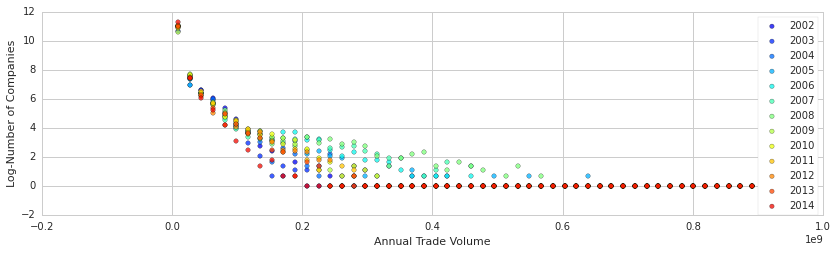

In [119]:
# To screen for anomalies and get a better feel for the data,
# I took a look at the trade-volume distributions by year.

fig = pyplot.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# make a colormap
cmap = pyplot.get_cmap('jet')
# 13 is the number of different colors we want
colors = cmap(numpy.linspace(0.1,0.9,13))
for i in range(13):
    # where 900m is roughly the global max in variance over the time period
    n, bins, patches = ax1.hist(annualTradeVolumes[years[i]],bins=50, range=(0,900000000))
    bins_mean = [0.5 * (bins[j] + bins[j+1]) for j in range(len(n))]
    ax2.scatter(bins_mean, map(lambda x: math.log(x) if x>1 else 0, n), c=colors[i], label=years[i], alpha = 0.75)
    ax2.legend()
    pyplot.xlabel("Annual Trade Volume")
    pyplot.ylabel("Log-Number of Companies")
# delete the first subplot -- we don't need it, we only had to construct it to derive the second
fig.delaxes(ax1)
pyplot.draw()

The plot above isn't particularly critical to drawing conclusions -- it just supplies further intuition for the structure of the annual trade volume data. Sometimes it's important to play with the data and make plots like this just to better understand it.

The plot is useful in that it shows that the dispersion of the number of companies trading at a certain trade volume has changed slightly over the years: between 2005 and 2009, far more stocks were trading at higher volumes, compared to recent years as well as 2002-2003. I have no immediate explanation for this phenomenon. 

Note that the red dots at the bottom are masking dots from other years, and that a value of 0 on the log-scale corresponds to 1 in actuality.

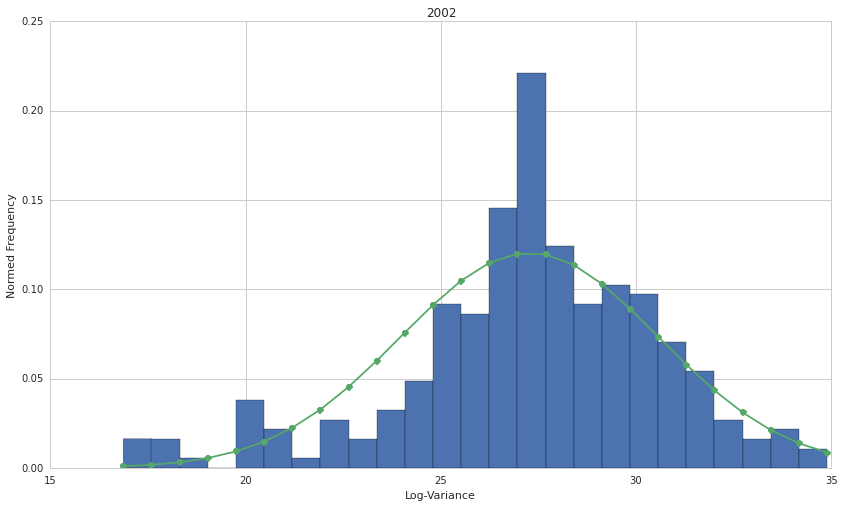

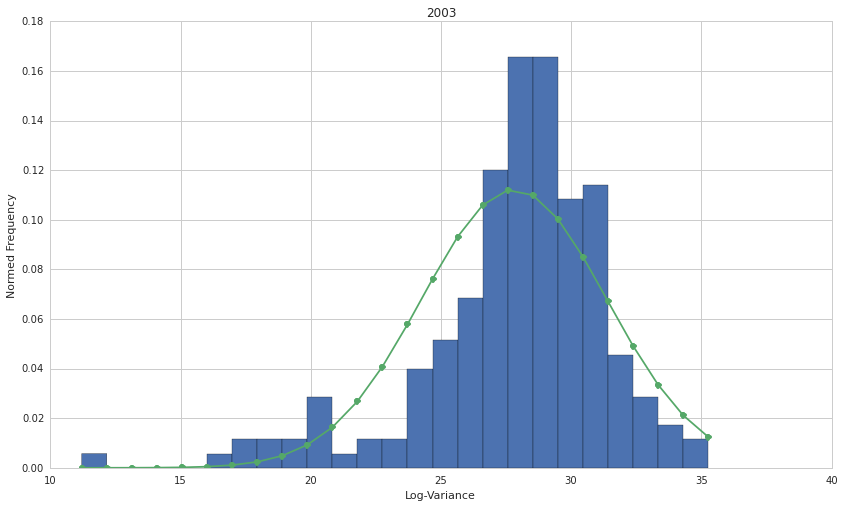

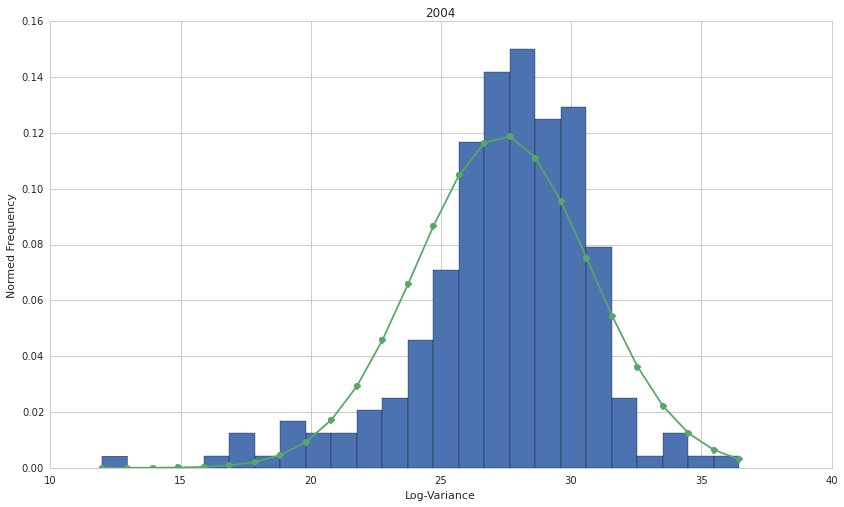

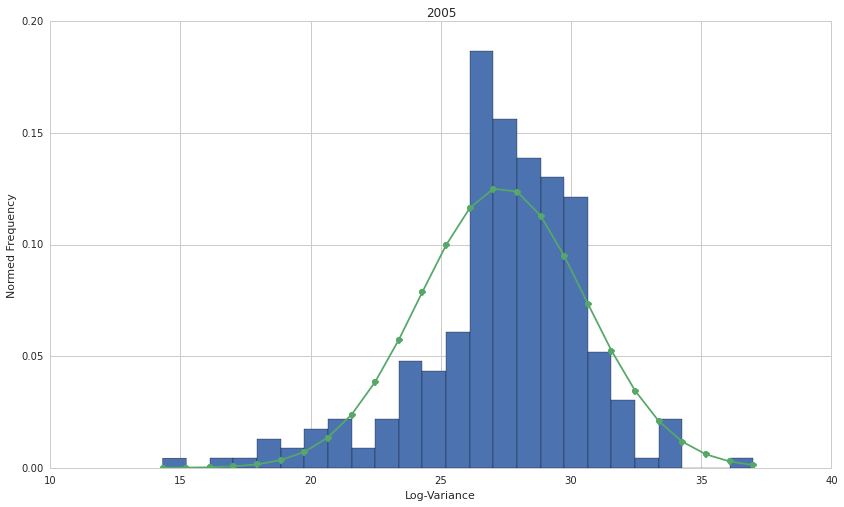

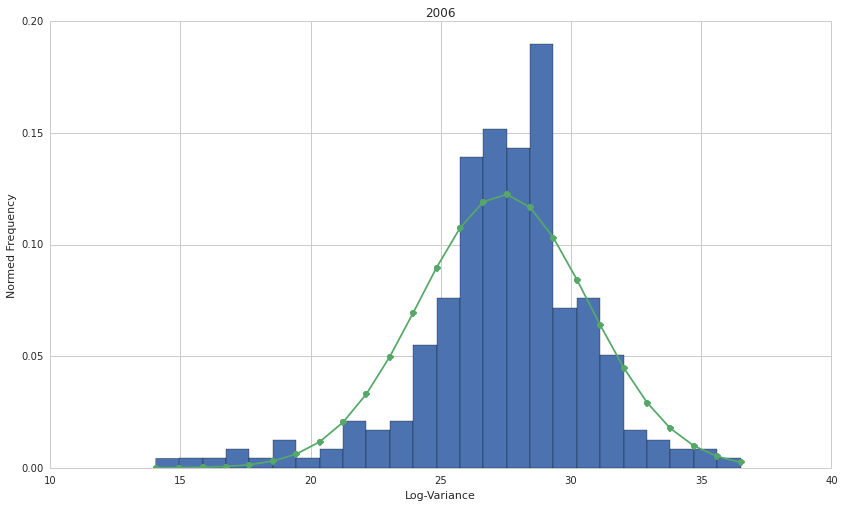

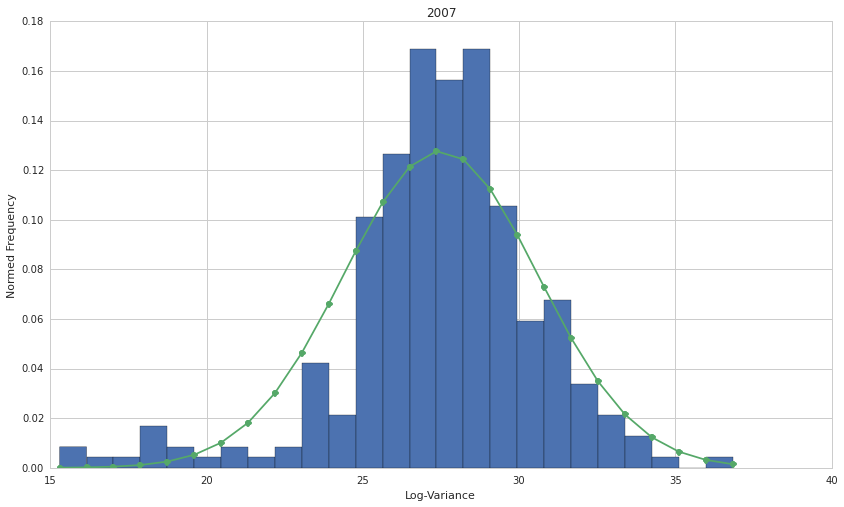

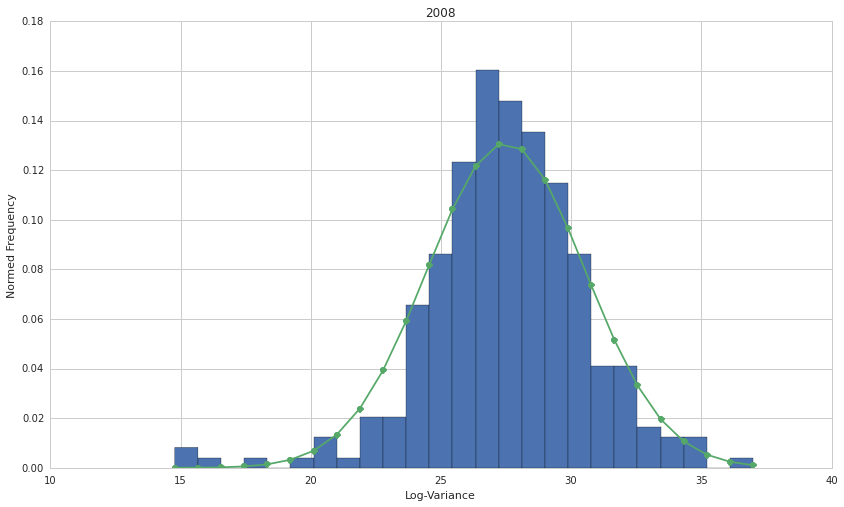

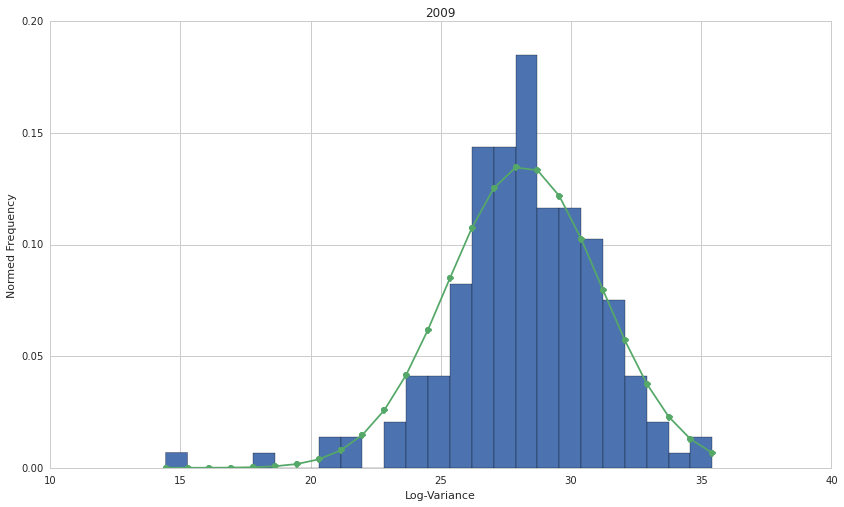

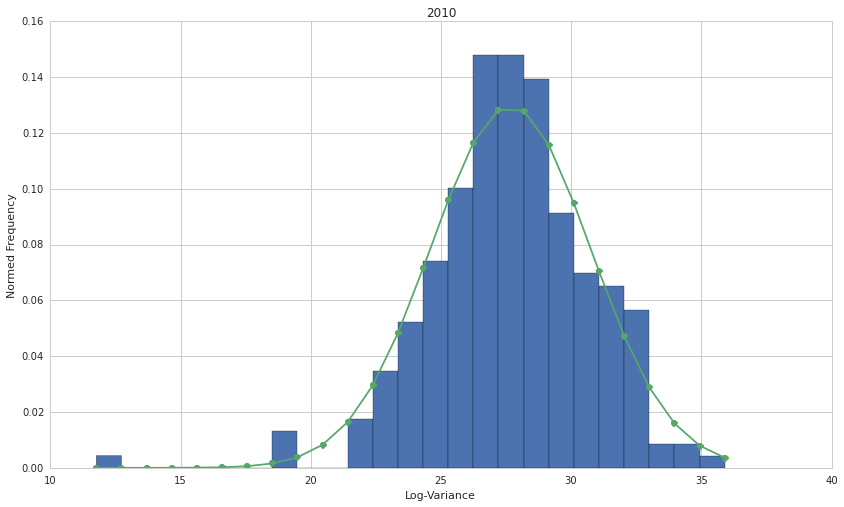

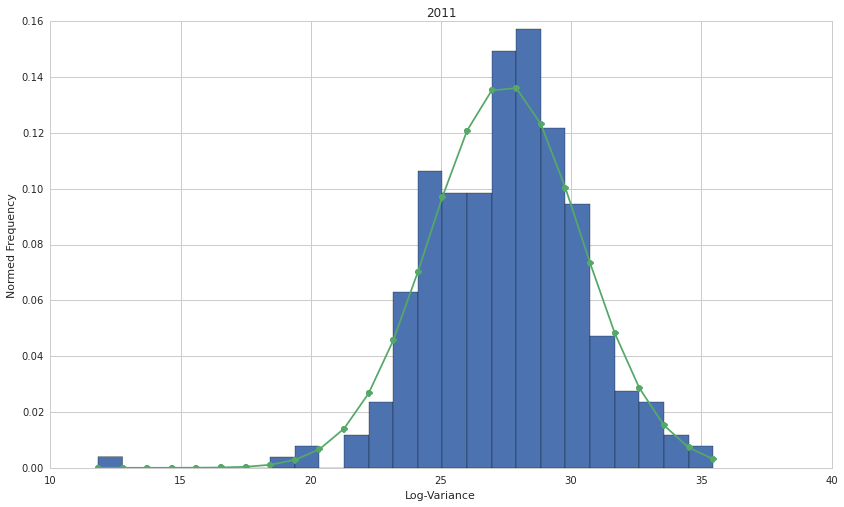

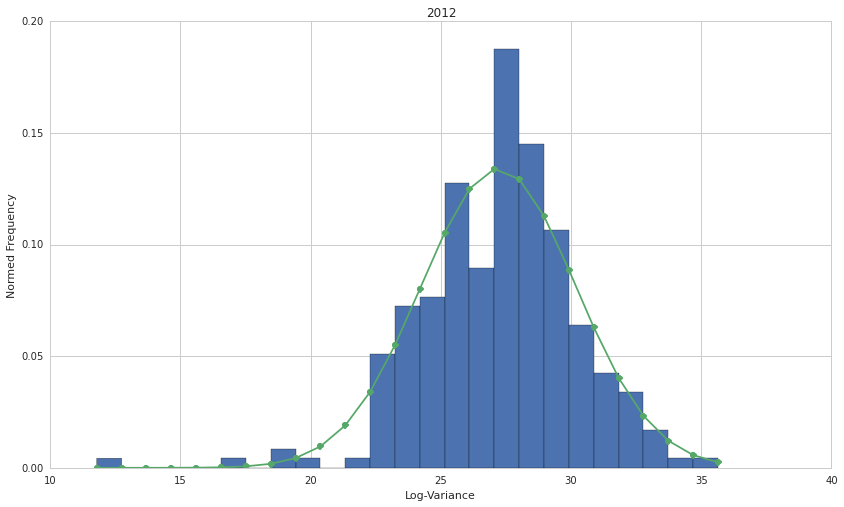

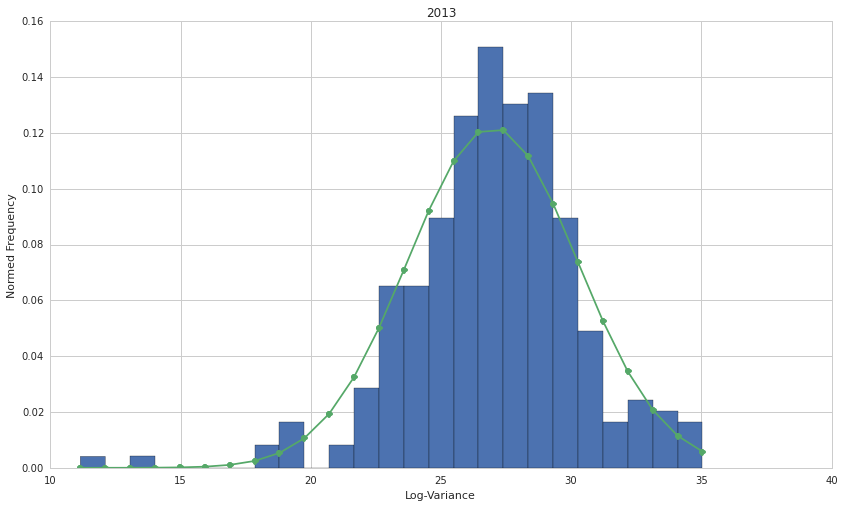

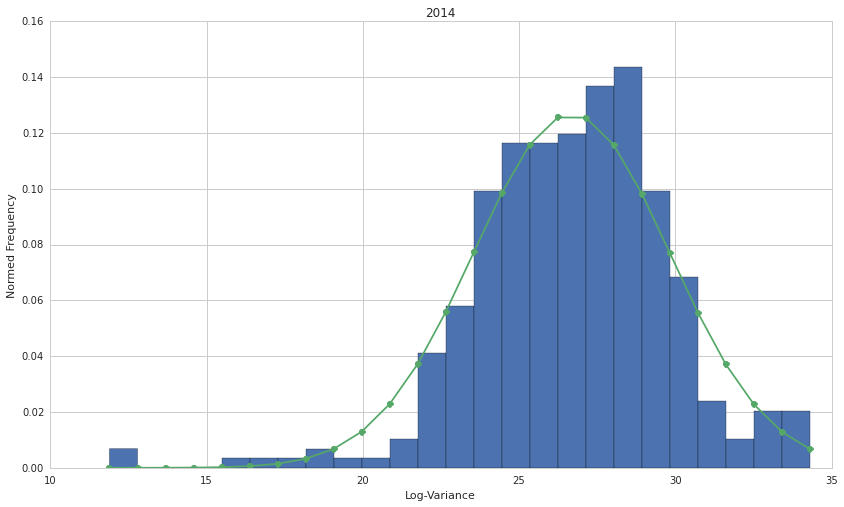

In [133]:
# For every year: plot the log of the variances in trade volume, and fit a normal distribution to it

for i in range(13):
    year = years[i]
    variances = sorted([math.log(x) for x in annualVariances[year] if not (numpy.isnan(x) or x==0)])
    # fitting the histogram
    n, bins, patches = pyplot.hist(variances,bins=25,normed=True)
    mu = numpy.mean(variances)
    sigma = numpy.std(variances)
    # fit a normal probability distribution to the data
    pdf = stats.norm.pdf(bins, mu, sigma)
    pyplot.title(str(year))
    pyplot.xlabel("Log-Variance")
    pyplot.ylabel("Normed Frequency")
    pyplot.plot(bins,pdf, '-o')
    pyplot.show()


What we see, in every year, is a distribution of log-variances that looks approximately normal. There clearly is a lot of noise and some abnormal skew/kurtosis, but on a whole, the pattern is reasonably clear. We can also consider the entire 13-year dataset in aggregate:

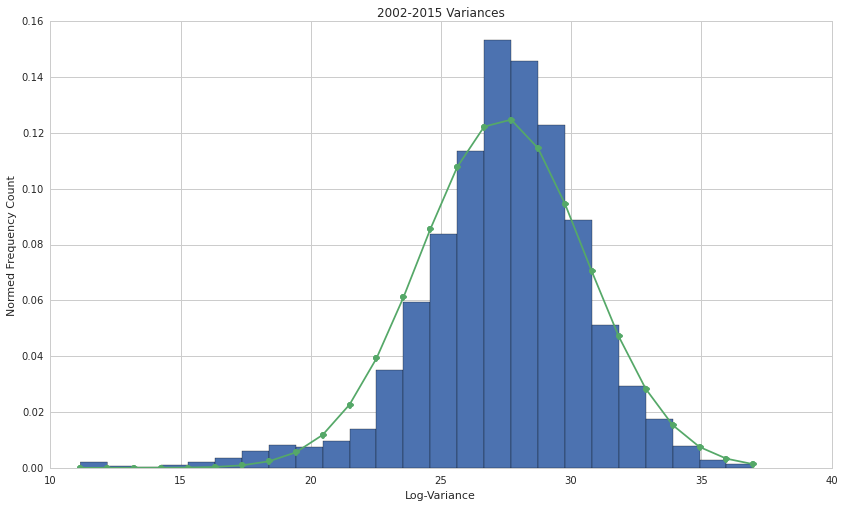

In [113]:
aggregateVariances = []

for i in range(13):
    aggregateVariances += [math.log(x) for x in annualVariances[years[i]] if not (numpy.isnan(x) or x==0)]
aggregateVariances.sort()

n, bins, patches = pyplot.hist(aggregateVariances,bins=25,normed=True)
mu = numpy.mean(aggregateVariances)
sigma = numpy.std(aggregateVariances)
# fit a normal probability distribution to the data
pdf = stats.norm.pdf(bins, mu, sigma)
pyplot.title("2002-2015 Variances")
pyplot.xlabel("Log-Variance")
pyplot.ylabel("Normed Frequency Count")
pyplot.plot(bins,pdf, '-o')
pyplot.show()

In aggregate, it seems clear that the log-variance is approximately normally distributed, i.e. that the variance is log-normally distributed. If we want more rigor, we can use a [normal probability plot](https://en.wikipedia.org/wiki/Normal_probability_plot) to confirm this result:

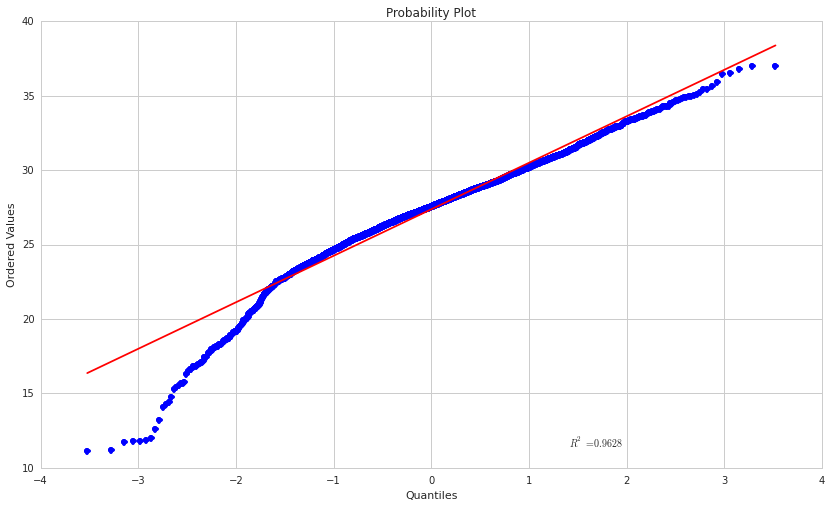

In [121]:
fig = pyplot.figure()
ax = fig.add_subplot(111)
stats.probplot(aggregateVariances, plot=ax)
pyplot.show()

Which shows, quite definitively, that the 2002-2015 log-variances are normally distributed, but deviate from the normal distribution at the very edges, which hints at some left skew, as we saw in the histograms. We've been looking at normal distributions, so it's important to note that this left skew implies that the log-normal distribution will also be very slightly left-skewed. 

Regardless, with an [$R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination) value of approximately 0.96, we can confidently conclude that this distribution is approximately normal. (In this case, you can think of $R^2$ as measuring the correlation between the data and the best-fitting normal distribution.)

However, we should keep in mind the edge-case deviations from the normal distribution.

### Further Questions

Some further questions come to mind:
    1. Is variance in trade volume also log-normally distributed in other industries?
    2. Is variance in trade volume also log-normally distributed over shorter time periods?
    
For the first question, we can find the answer easily by changing the sector code in the start of the notebook, and re-running all computations. I did this for a few sectors:
    - For sector code 310 (industrials), the answer is yes, but not as clearly -- the distribution is much more noisy, i.e. the data does not fit the log-normal distribution quite as well (R^2 = 0.916 on the normal probability plot).
    
    - For sector code 206 (healthcare), the answer is also yes, with many of the individual years fitting the log-normal distribution quite well, but the aggregate data fitting the log-normal distribution slightly less well. (R^2 = 0.919)
    
    - For sector code 102 (consumer cyclical), the answer is yes but with some caveats -- the distributions are generally quite skewed, and though the aggregate data has an R^2 of 0.916 on the normal probability plot, it looks as if it has the lowest kurtosis yet.
    
    - For sector code 309 (energy), there are some individual years that are quite noisy and not particularly well-described by a log-normal distribution, though many others are. In aggregate, the data fits the log-normal distribution very well (R^2 = 0.95).

For the second question, we can randomly select some 30-day and 90-day periods, one for every year. We go back to sector code 311 (technology) for this test. I used an online tool to generate the following random dates.

In [122]:
randomDates1 = ['2002-08-24', '2003-03-01', '2004-12-23', '2005-06-14', '2006-08-31', '2007-08-12',
              '2008-01-25','2009-02-16','2010-11-09','2011-05-28','2012-01-12','2013-05-10','2014-10-02']

randomDates2 = ['2002-02-14', '2003-10-11', '2004-08-30', '2005-03-09', '2006-12-02', '2007-05-21',
              '2008-06-15','2009-06-09','2010-02-25','2011-05-22','2012-12-31','2013-07-09','2014-05-29']

In [157]:
# Note that we'll only need the variance data.
thirtyTradeVolumes, thirtyVariances = getMultiDayData(randomDates,30)

In [158]:
ninetyTradeVolumes, ninetyVariances = getMultiDayData(randomDates,90)

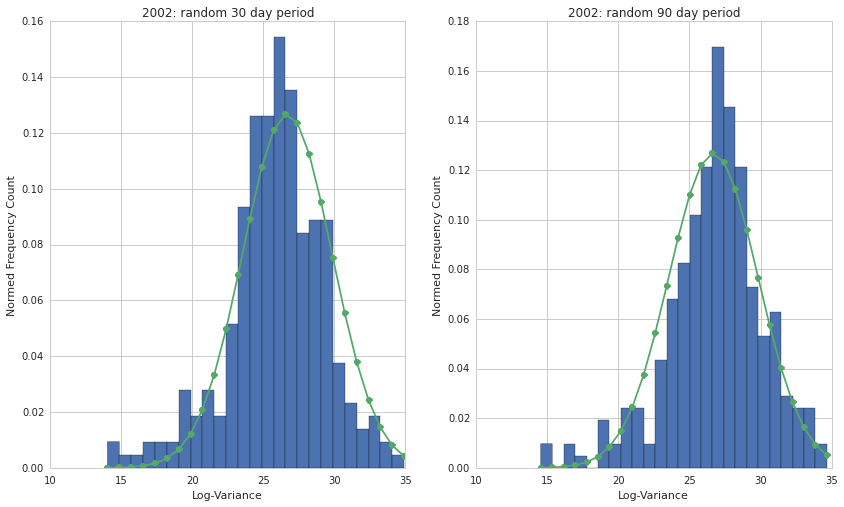

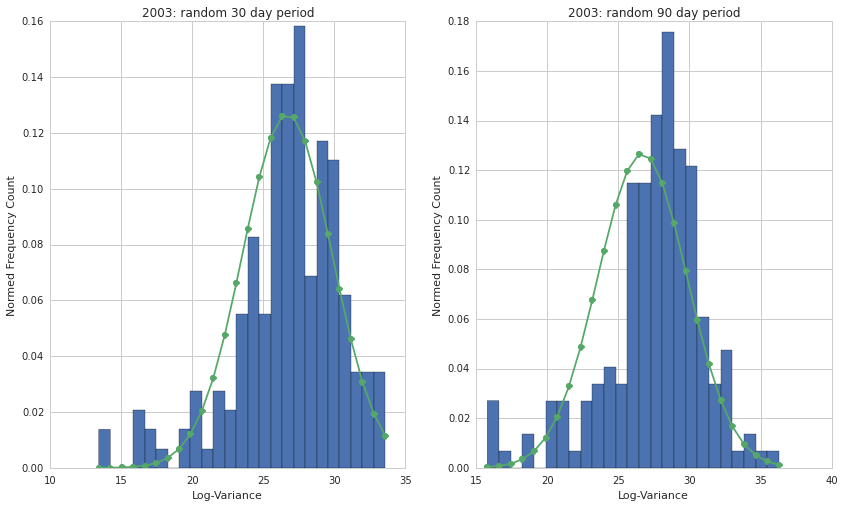

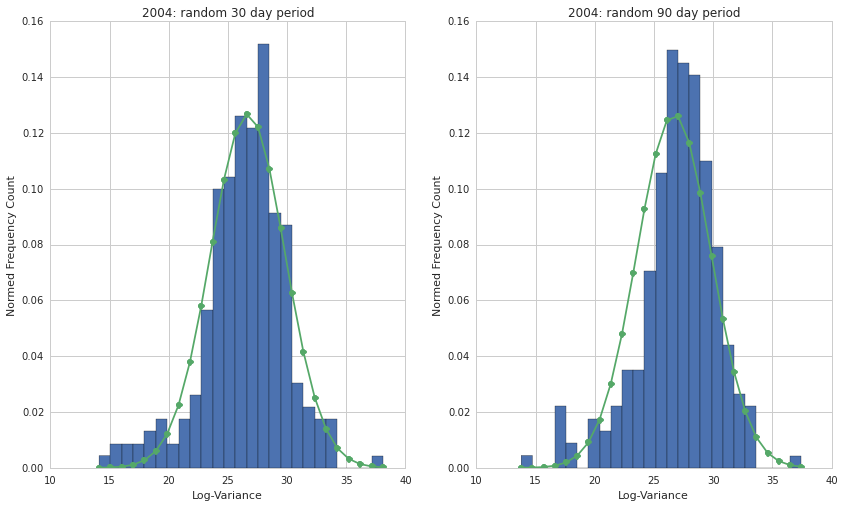

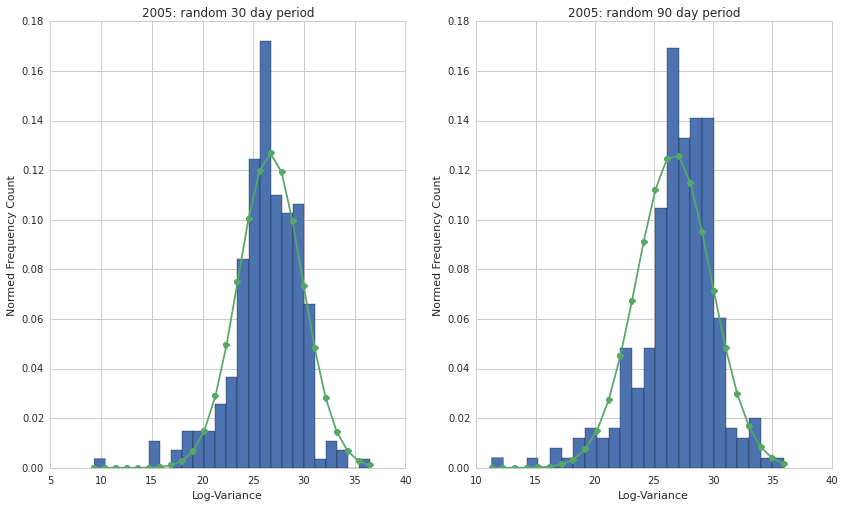

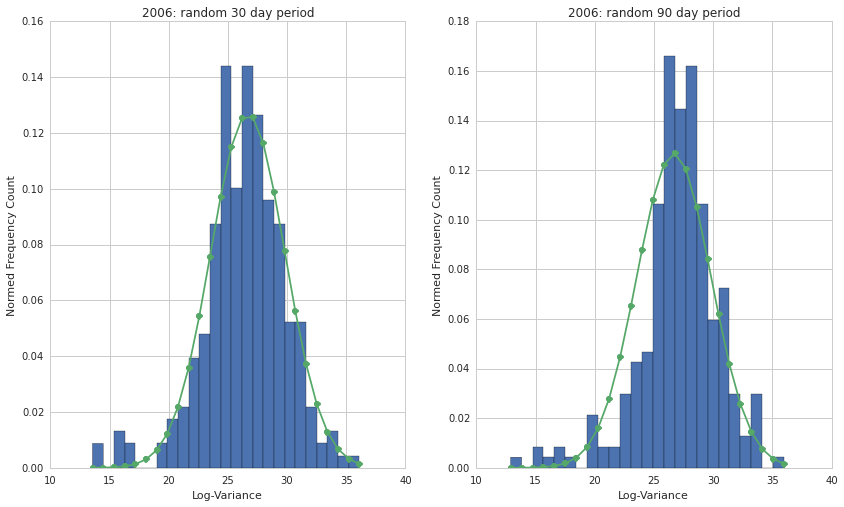

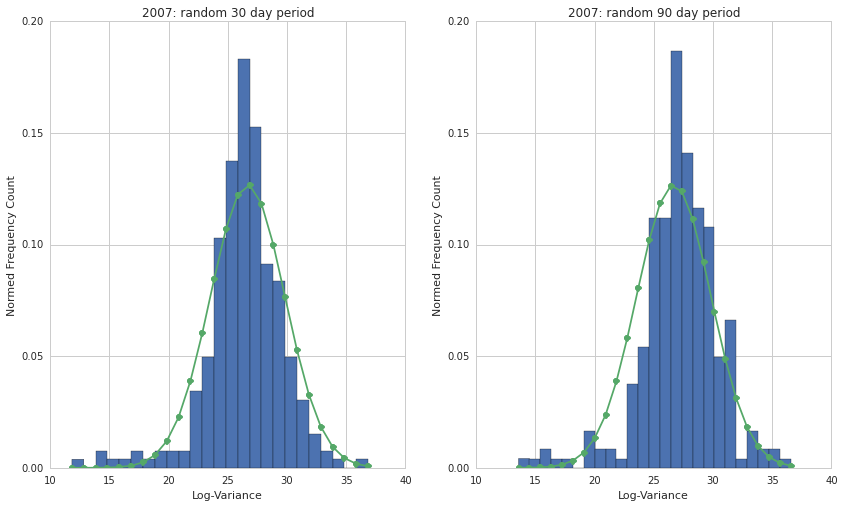

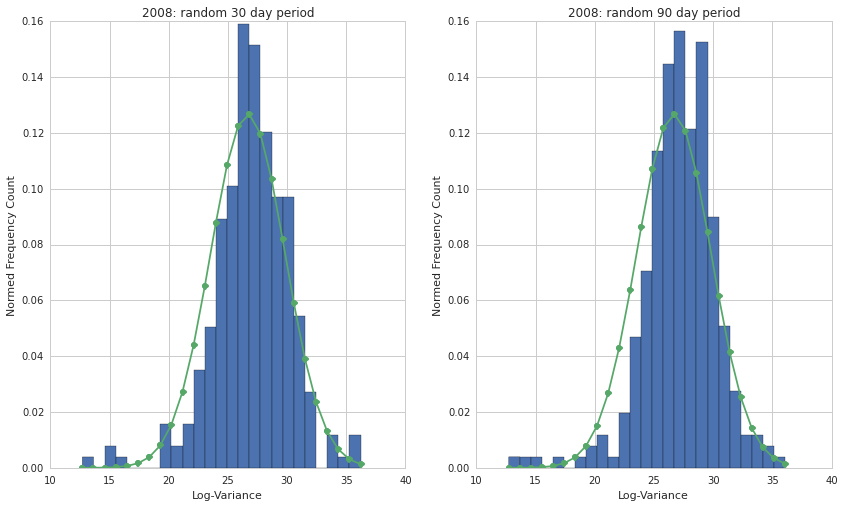

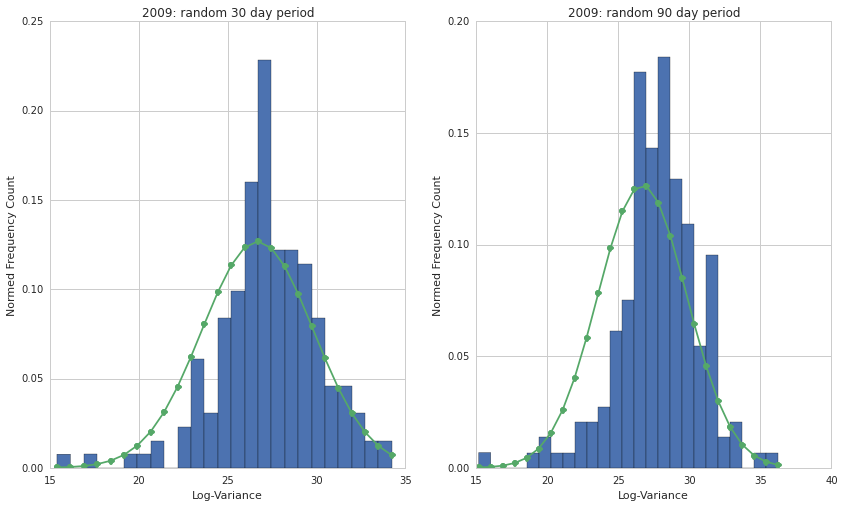

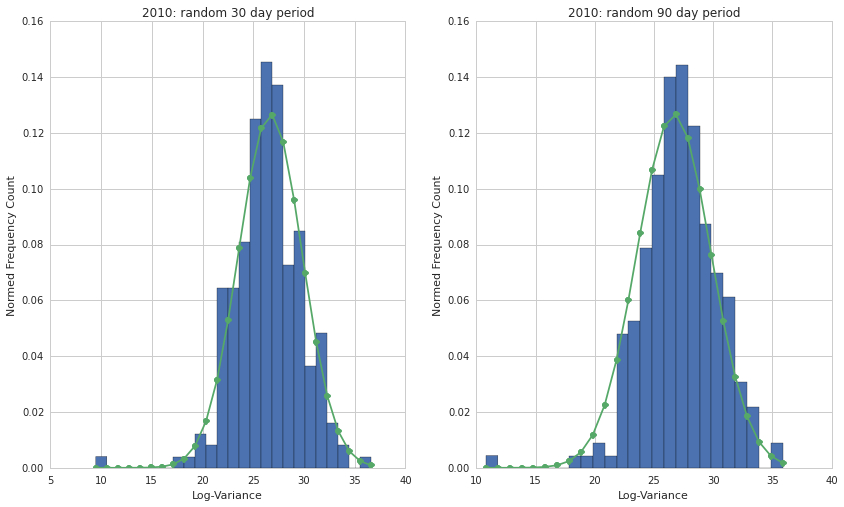

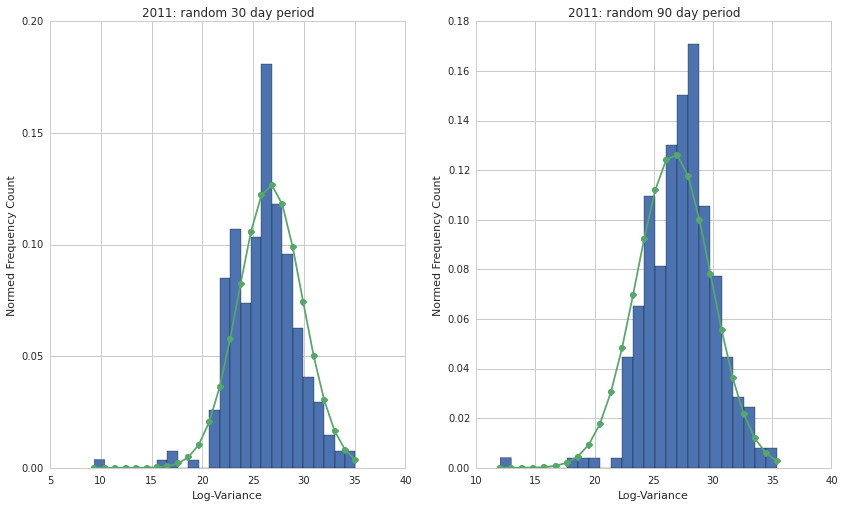

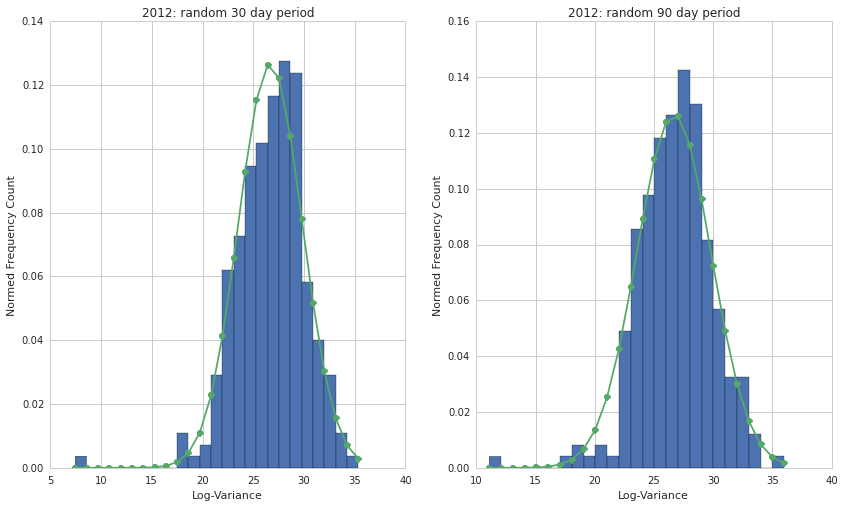

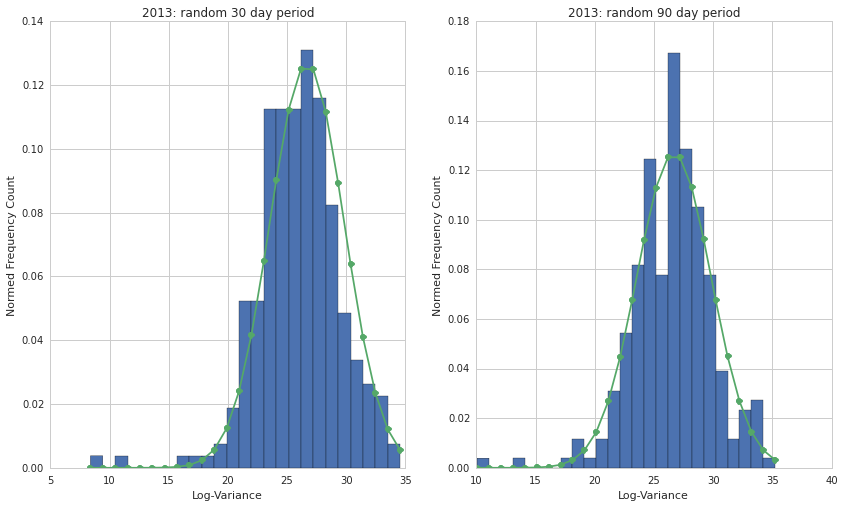

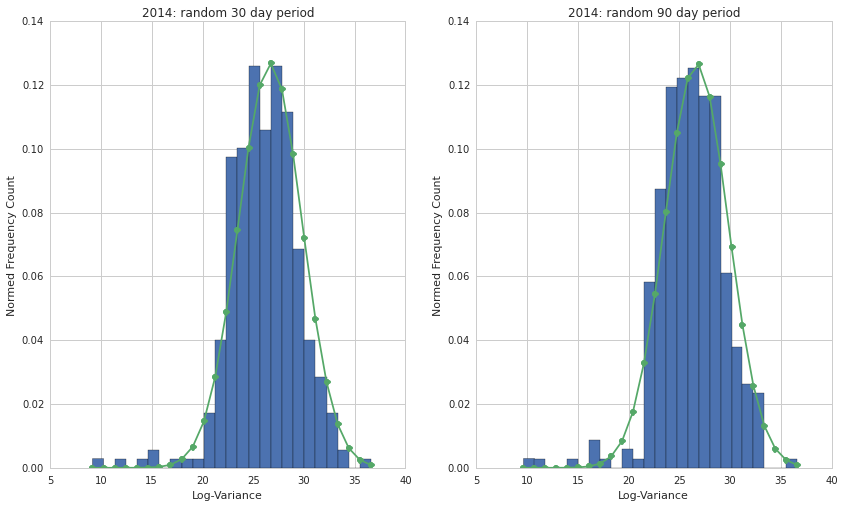

In [159]:
# To save space, for every year we'll display the plot for the 30-day data
# next to the plot of the 90-day data.

aggregateV30 = []
aggregateV90 = []

for i in range(13):
    year = years[i]
    variances30 = sorted([math.log(x) for x in thirtyVariances[year] if not (numpy.isnan(x) or x==0)])
    variances90 = sorted([math.log(x) for x in ninetyVariances[year] if not (numpy.isnan(x) or x==0)])
    
    # add to the aggregate variances for these shorter periods
    aggregateV30 += variances30
    aggregateV90 += variances90
    
    # make the left plot
    pyplot.subplot(121)
    n, bins, patches = pyplot.hist(variances30,bins=25,normed=True)
    mu = numpy.mean(variances)
    sigma = numpy.std(variances)
    pdf = stats.norm.pdf(bins, mu, sigma)
    pyplot.title(str(year)+ ": random 30 day period")
    pyplot.xlabel("Log-Variance")
    pyplot.ylabel("Normed Frequency Count")
    pyplot.plot(bins,pdf, '-o')

    # right plot
    pyplot.subplot(122)
    n, bins, patches = pyplot.hist(variances90,bins=25,normed=True)
    mu = numpy.mean(variances)
    sigma = numpy.std(variances)
    pdf = stats.norm.pdf(bins, mu, sigma)
    pyplot.title(str(year) + ": random 90 day period")
    pyplot.xlabel("Log-Variance")
    pyplot.ylabel("Normed Frequency Count")
    pyplot.plot(bins,pdf, '-o')
    
    pyplot.show()

These are much like the annual plots we saw earlier, except that they're slightly noisier and thus slightly less well-described by the normal distribution. But that's to be expected -- the time periods are shorter, so we're taking fewer samples, so the approximation of the distribution will be more crude.

In the code above, we also collected data so we could make aggregate plots of these periods over all ten years, again, much like with the annual data. Here they are:

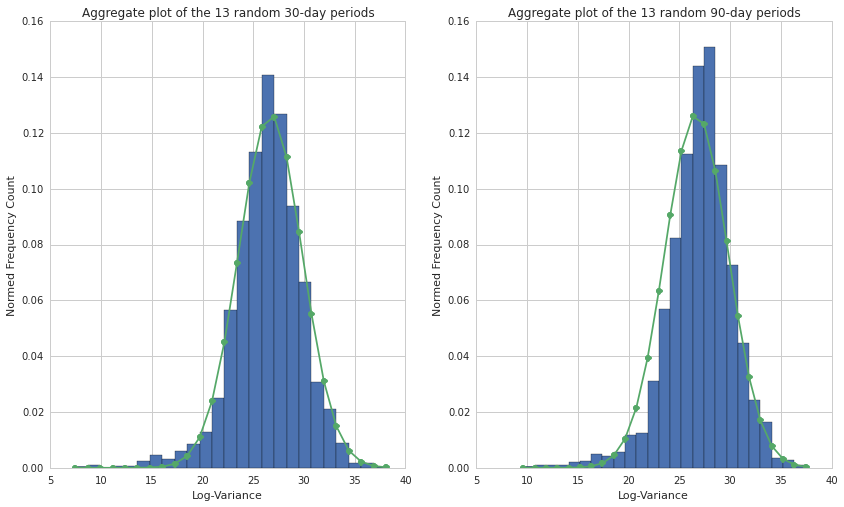

In [160]:
# make the left plot
pyplot.subplot(121)
n, bins, patches = pyplot.hist(aggregateV30,bins=25,normed=True)
mu = numpy.mean(variances)
sigma = numpy.std(variances)
pdf = stats.norm.pdf(bins, mu, sigma)
pyplot.title("Aggregate plot of the 13 random 30-day periods")
pyplot.xlabel("Log-Variance")
pyplot.ylabel("Normed Frequency Count")
pyplot.plot(bins,pdf, '-o')

# right plot
pyplot.subplot(122)
n, bins, patches = pyplot.hist(aggregateV90,bins=25,normed=True)
mu = numpy.mean(variances)
sigma = numpy.std(variances)
pdf = stats.norm.pdf(bins, mu, sigma)
pyplot.title("Aggregate plot of the 13 random 90-day periods")
pyplot.xlabel("Log-Variance")
pyplot.ylabel("Normed Frequency Count")
pyplot.plot(bins,pdf, '-o')

pyplot.show()

These look very normal! Just for the sake of completion, we'll do two corresponding normal probability plots:

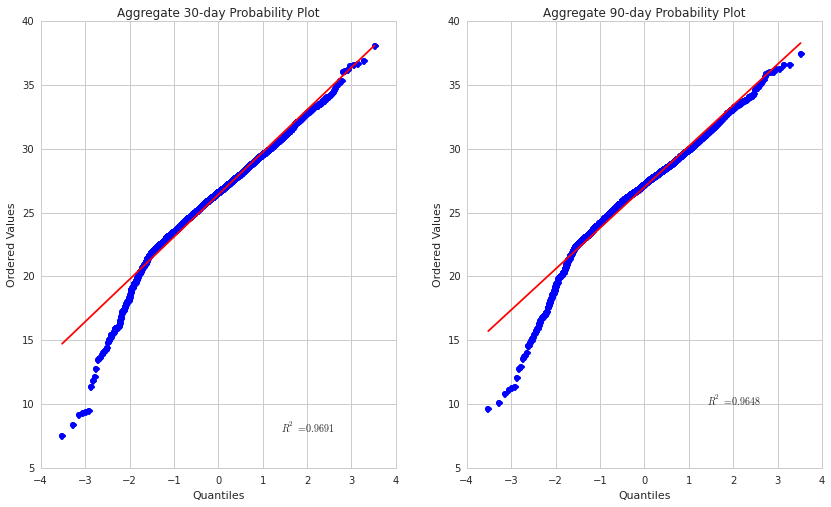

In [161]:
pyplot.subplot(121)
stats.probplot(aggregateV30, plot=pyplot)
pyplot.title("Aggregate 30-day Probability Plot")

pyplot.subplot(122)
stats.probplot(aggregateV90, plot=pyplot)
pyplot.title("Aggregate 90-day Probability Plot")

pyplot.show()

Both of which are totally commensurate with the result for the annual case. Note that both of these plots actually have slightly higher $R^2$ values, which suggests that we got a little bit lucky with our 30- and 90-day random samples. In any case, we conclude that variance in trade-volume is also log-normally distributed over shorter time periods.

For good measure, I also repeated the above computations for even shorter time periods -- 10 days and 20 days starting from a new set of random dates, which were, as expected, a little noisier but still totally commensurate with the above results (in aggregate, $R^2 \approx 0.95$ in both cases).

Finally, note that there is an opportunity to do equivalent investigations for small-cap stocks.

*Note: I left this unmentioned, but the distribution also holds (equally well) for daily minute data, even for very small intervals (though they may be noisier just due to a smaller sample size): the smallest I tested was twenty minutes. Should include some minute-level tests.*